# AI Second Project - Food_DataSet - Training_Models :)

## Episode1 - Read Data And Doing Some Pre_Processing

### Arc1 - Split Data Training

In [1]:
# import libraries we want
# pandas and numpy to work with dataFrame
import pandas as pd
import numpy as np
# tensorflow for make model
import tensorflow as tf
from tensorflow . keras . preprocessing.image import ImageDataGenerator
from tensorflow . keras . applications import MobileNetV2, ResNet50
from tensorflow . keras . layers import Dense, Dropout
from tensorflow . keras . models import Model
from sklearn . model_selection import train_test_split
# PIL library to use some process on image easy
from PIL import Image
import io
# use in the last part to have some correcting
import matplotlib.pyplot as plt

In [2]:
def preprocess_image(image_bytes):
    # open the image from raw bytes
    image = Image.open(io.BytesIO(eval(image_bytes)))
    # resize image to a fixed size
    image = image.resize((224, 224))
    # convert image to numpy array
    image_array = np.array(image)
    return image_array

In [3]:
# create generators from a dataframe
def create_generators(df):
    # use previous function on main DataFrame
    df['Photo'] = df['Photo'] . apply(preprocess_image)
    df = df[df['Photo'].apply(lambda x: x.shape == (224, 224, 3))]
    # split data into 2 part_ train and validation part 
    X_train, X_val, y_train, y_val = train_test_split(np . stack(df['Photo'] . values), df['Label'] . values, test_size = 0.2, random_state = 42)
    # make generators - we only use generator on train data and we don't change anything in validation data
    train_datagen = ImageDataGenerator(
    rescale = 1./255,  # Normalize pixel values to [0,1]
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
    )
    val_datagen = ImageDataGenerator(rescale = 1./255)
    # use above augmentation for data
    train_generator = train_datagen . flow(X_train, y_train, batch_size = 32)
    val_generator = val_datagen . flow(X_val, y_val, batch_size = 32)
    return train_generator, val_generator

In [4]:
# check df1
df1 = pd . read_csv('high.csv')  # High Accuracy

In [5]:
train_gen1, val_gen1 = create_generators(df1)

In [4]:
df2 = pd . read_csv('mid.csv')

In [5]:
train_gen2, val_gen2 = create_generators(df2)

In [4]:
df3 = pd . read_csv('low.csv')

In [5]:
train_gen3, val_gen3 = create_generators(df3)

### Arc2 - All Data Maker

In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to create training and validation generators from a directory
def create_generators(image_dir, img_size=(224, 224), batch_size=32):
    # ImageDataGenerator with data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,                  # Normalize pixel values to [0, 1]
        rotation_range=20,               # Randomly rotate images
        zoom_range=0.2,                  # Randomly zoom images
        width_shift_range=0.2,           # Randomly shift images horizontally
        height_shift_range=0.2,          # Randomly shift images vertically
        horizontal_flip=True,            # Randomly flip images horizontally
        fill_mode='nearest',             # Fill pixels when shifts happen
        validation_split=0.2             # Split data into training and validation
    )
    
    # ImageDataGenerator for validation (only rescaling, no augmentation)
    val_datagen = ImageDataGenerator(
        rescale=1./255,                  # Normalize pixel values to [0, 1]
        validation_split=0.2             # Same split as training
    )
    
    # Training generator
    train_generator = train_datagen.flow_from_directory(
        image_dir,
        target_size=img_size,            # Resize images to the specified size
        batch_size=batch_size,           # Number of images per batch
        class_mode='categorical',        # Use 'categorical' since it's a multi-class classification problem
        subset='training',               # Use the training subset
        shuffle=True                     # Shuffle images for training
    )
    
    # Validation generator
    val_generator = val_datagen.flow_from_directory(
        image_dir,
        target_size=img_size,            # Resize images to the specified size
        batch_size=batch_size,           # Number of images per batch
        class_mode='categorical',        # Use 'categorical' for multi-class classification
        subset='validation',             # Use the validation subset
        shuffle=False                    # No shuffle for validation
    )
    
    # Ensure that both training and validation have 101 classes
    assert len(train_generator.class_indices) == 101, "Training set doesn't contain 101 classes."
    assert len(val_generator.class_indices) == 101, "Validation set doesn't contain 101 classes."
    
    return train_generator, val_generator

# Example usage
image_dir = "images"
train_gen, val_gen = create_generators(image_dir)

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


## Episode2 - Train The High.csv 2 Times On Model

### Part1 Training - No Trainable Layer

In [6]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(101, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Freeze the base model's layers to use transfer learning
    for layer in base_model.layers:
        layer.trainable = False   
    return model

In [9]:
# make model
model = create_model()
# give summary
model . summary()

87910968/87910968 [==============================] - 72s 1us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                 

In [13]:
model . compile(optimizer = tf.keras.optimizers.Adam(1e-3), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [14]:
model . fit(train_gen1, validation_data = val_gen1, epochs = 5)
# save the weights of model in .h5 file
model . save_weights('model1.h5')

Epoch 1/5
928/928 [==============================] - 904s 970ms/step - loss: 2.3439 - accuracy: 0.3526 - val_loss: 1.6210 - val_accuracy: 0.5412
Epoch 2/5
928/928 [==============================] - 967s 1s/step - loss: 2.0296 - accuracy: 0.4258 - val_loss: 1.6143 - val_accuracy: 0.5383
Epoch 3/5
928/928 [==============================] - 991s 1s/step - loss: 1.9631 - accuracy: 0.4427 - val_loss: 1.5742 - val_accuracy: 0.5523
Epoch 4/5
928/928 [==============================] - 913s 984ms/step - loss: 1.9159 - accuracy: 0.4568 - val_loss: 1.5041 - val_accuracy: 0.5726
Epoch 5/5
928/928 [==============================] - 892s 961ms/step - loss: 1.8811 - accuracy: 0.4682 - val_loss: 1.4916 - val_accuracy: 0.5761


### Part2 - 100 First Layer Is Non_Trainable

In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(101, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Fine-tuning: unfreeze some layers and continue training
    base_model.trainable = True
    fine_tune_at = 100  # Choose where to start fine-tuning
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False  
    return model

In [11]:
# make model
model = create_model()
# give summary
model . summary()
model . load_weights('model1.h5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [14]:
# Compile the model again with a lower learning rate
model . compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [15]:
model . fit(train_gen1, validation_data = val_gen1, epochs = 5)
# save the weights of model in .h5 file
model . save_weights('model2.h5')

Epoch 1/5
928/928 [==============================] - 2054s 2s/step - loss: 1.6205 - accuracy: 0.5514 - val_loss: 1.1029 - val_accuracy: 0.7057
Epoch 2/5
928/928 [==============================] - 2029s 2s/step - loss: 1.1941 - accuracy: 0.6671 - val_loss: 1.0267 - val_accuracy: 0.7279
Epoch 3/5
928/928 [==============================] - 2026s 2s/step - loss: 1.0151 - accuracy: 0.7170 - val_loss: 0.9524 - val_accuracy: 0.7468
Epoch 4/5
928/928 [==============================] - 2146s 2s/step - loss: 0.9048 - accuracy: 0.7481 - val_loss: 0.9762 - val_accuracy: 0.7492
Epoch 5/5
928/928 [==============================] - 1997s 2s/step - loss: 0.8087 - accuracy: 0.7725 - val_loss: 0.8943 - val_accuracy: 0.7709


## Episode3 - Train The Mid.csv 2 Times On Model

### Part1 Training - No Trainable Layer

In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(101, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Freeze the base model's layers to use transfer learning
    for layer in base_model.layers:
        layer.trainable = False   
    return model

In [9]:
# make model
model = create_model()
model . load_weights('model2.h5')
# give summary
model . summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [10]:
model . compile(optimizer = tf.keras.optimizers.Adam(1e-3), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [11]:
model . fit(train_gen2, validation_data = val_gen2, epochs = 5)
# save the weights of model in .h5 file
model . save_weights('model2.h5')

Epoch 1/5
853/853 [==============================] - 828s 966ms/step - loss: 3.2470 - accuracy: 0.1579 - val_loss: 2.0394 - val_accuracy: 0.4298
Epoch 2/5
853/853 [==============================] - 828s 971ms/step - loss: 2.3693 - accuracy: 0.3245 - val_loss: 1.7627 - val_accuracy: 0.5034
Epoch 3/5
853/853 [==============================] - 812s 952ms/step - loss: 2.1572 - accuracy: 0.3778 - val_loss: 1.6291 - val_accuracy: 0.5367
Epoch 4/5
853/853 [==============================] - 804s 943ms/step - loss: 2.0190 - accuracy: 0.4206 - val_loss: 1.5500 - val_accuracy: 0.5652
Epoch 5/5
853/853 [==============================] - 808s 947ms/step - loss: 1.9426 - accuracy: 0.4416 - val_loss: 1.4789 - val_accuracy: 0.5857


### Part2 - 100 First Layer Is Non_Trainable

In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(101, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Fine-tuning: unfreeze some layers and continue training
    base_model.trainable = True
    fine_tune_at = 100  # Choose where to start fine-tuning
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False  
    return model

In [14]:
# make model
model = create_model()
# give summary
model . summary()
model . load_weights('model2.h5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [15]:
model . compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [16]:
# compile model and train it
model . fit(train_gen2, validation_data = val_gen2, epochs = 5)
# save model
model . save_weights('model3.h5')

Epoch 1/5
853/853 [==============================] - 1833s 2s/step - loss: 1.7583 - accuracy: 0.5037 - val_loss: 1.1869 - val_accuracy: 0.6735
Epoch 2/5
853/853 [==============================] - 1801s 2s/step - loss: 1.4470 - accuracy: 0.5981 - val_loss: 1.0618 - val_accuracy: 0.7134
Epoch 3/5
853/853 [==============================] - 1808s 2s/step - loss: 1.2711 - accuracy: 0.6523 - val_loss: 1.0383 - val_accuracy: 0.7187
Epoch 4/5
853/853 [==============================] - 1818s 2s/step - loss: 1.1598 - accuracy: 0.6852 - val_loss: 0.9644 - val_accuracy: 0.7451
Epoch 5/5
853/853 [==============================] - 1822s 2s/step - loss: 1.0324 - accuracy: 0.7184 - val_loss: 0.9327 - val_accuracy: 0.7607


## Episode4 - Train The Low.csv 2 Times On Model

### Part1 Training - No Trainable Layer

In [6]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(101, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Freeze the base model's layers to use transfer learning
    for layer in base_model.layers:
        layer.trainable = False   
    return model

In [7]:
# make model and load weights
model = create_model()
model.load_weights('model3.h5')

In [8]:
model . compile(optimizer = tf . keras.optimizers . Adam(1e-3), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen3, validation_data = val_gen3, epochs = 5)
model . save_weights('model4.h5')

Epoch 1/5
753/753 [==============================] - 771s 1s/step - loss: 3.1750 - accuracy: 0.1878 - val_loss: 1.7265 - val_accuracy: 0.5488
Epoch 2/5
753/753 [==============================] - 709s 942ms/step - loss: 2.1391 - accuracy: 0.3973 - val_loss: 1.4420 - val_accuracy: 0.6226
Epoch 3/5
753/753 [==============================] - 694s 921ms/step - loss: 1.9018 - accuracy: 0.4580 - val_loss: 1.3028 - val_accuracy: 0.6542
Epoch 4/5
753/753 [==============================] - 692s 918ms/step - loss: 1.7811 - accuracy: 0.4934 - val_loss: 1.2431 - val_accuracy: 0.6638
Epoch 5/5
753/753 [==============================] - 699s 928ms/step - loss: 1.6871 - accuracy: 0.5188 - val_loss: 1.1611 - val_accuracy: 0.6774


### Part2 - 100 First Layer Is Non_Trainable

In [9]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(101, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Fine-tuning: unfreeze some layers and continue training
    base_model.trainable = True
    fine_tune_at = 100  # Choose where to start fine-tuning
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False  
    return model

In [10]:
# make model
model = create_model()
# give summary
model . summary()
model . load_weights('model4.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [11]:
# compile model
model . compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [12]:
# compile model and train
model . fit(train_gen3, validation_data = val_gen3, epochs = 5)
# save model
model . save_weights('model5.h5')

Epoch 1/5
753/753 [==============================] - 1674s 2s/step - loss: 1.4638 - accuracy: 0.5964 - val_loss: 0.8759 - val_accuracy: 0.7678
Epoch 2/5
753/753 [==============================] - 1723s 2s/step - loss: 1.1519 - accuracy: 0.6911 - val_loss: 0.7718 - val_accuracy: 0.7942
Epoch 3/5
753/753 [==============================] - 1719s 2s/step - loss: 0.9763 - accuracy: 0.7401 - val_loss: 0.6737 - val_accuracy: 0.8221
Epoch 4/5
753/753 [==============================] - 1644s 2s/step - loss: 0.8663 - accuracy: 0.7716 - val_loss: 0.6359 - val_accuracy: 0.8382
Epoch 5/5
753/753 [==============================] - 1661s 2s/step - loss: 0.7684 - accuracy: 0.8025 - val_loss: 0.6383 - val_accuracy: 0.8367


## Episode5 - Train All Data On Model

### Part1 Training - No Trainable Layer

In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(101, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Freeze the base model's layers to use transfer learning
    for layer in base_model.layers:
        layer.trainable = False   
    return model

In [3]:
# make model and load weights
model = create_model()
model.load_weights('model5.h5')

In [6]:
model . compile(optimizer = tf . keras.optimizers . Adam(1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model . fit(train_gen, validation_data = val_gen, epochs = 5)
model . save_weights('model_final_1.h5')

Epoch 1/5
2525/2525 [==============================] - 4104s 2s/step - loss: 3.0172 - accuracy: 0.3009 - val_loss: 1.7293 - val_accuracy: 0.5675
Epoch 2/5
2525/2525 [==============================] - 2257s 894ms/step - loss: 2.2393 - accuracy: 0.4464 - val_loss: 1.5658 - val_accuracy: 0.6066
Epoch 3/5
2525/2525 [==============================] - 2258s 893ms/step - loss: 2.1026 - accuracy: 0.4778 - val_loss: 1.5162 - val_accuracy: 0.6150
Epoch 4/5
2525/2525 [==============================] - 2251s 891ms/step - loss: 2.0346 - accuracy: 0.4925 - val_loss: 1.4587 - val_accuracy: 0.6257
Epoch 5/5
2525/2525 [==============================] - 2259s 895ms/step - loss: 1.9873 - accuracy: 0.5039 - val_loss: 1.4499 - val_accuracy: 0.6331


### Part2 - 100 First Layer Is Non_Trainable

In [16]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(101, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Fine-tuning: unfreeze some layers and continue training
    base_model.trainable = True
    fine_tune_at = 100  # Choose where to start fine-tuning
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False  
    return model

In [17]:
# make model and freeze first 100 layer
model = create_model()
model . load_weights('model_final_1.h5')

In [18]:
# compile model
model . compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [19]:
# compile model and train
model . fit(train_gen, validation_data = val_gen, epochs = 5)
# save model
model . save_weights('model_final_2.h5')

Epoch 1/5
2525/2525 [==============================] - 5158s 2s/step - loss: 1.9314 - accuracy: 0.5288 - val_loss: 1.3213 - val_accuracy: 0.6751
Epoch 2/5
2525/2525 [==============================] - 5092s 2s/step - loss: 1.6684 - accuracy: 0.5955 - val_loss: 1.2057 - val_accuracy: 0.7052
Epoch 3/5
2525/2525 [==============================] - 5095s 2s/step - loss: 1.5050 - accuracy: 0.6346 - val_loss: 1.1970 - val_accuracy: 0.7143
Epoch 4/5
2525/2525 [==============================] - 5331s 2s/step - loss: 1.3818 - accuracy: 0.6659 - val_loss: 1.1901 - val_accuracy: 0.7201
Epoch 5/5
2525/2525 [==============================] - 5321s 2s/step - loss: 1.2736 - accuracy: 0.6924 - val_loss: 1.1687 - val_accuracy: 0.7242


### Arc3 - All Layer Trainable

In [9]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(101, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Fine-tuning: unfreeze some layers and continue training
    base_model.trainable = True
    for layer in base_model.layers:
        layer.trainable = True  
    return model

In [10]:
# make model and freeze first 100 layer
model = create_model()
model . load_weights('model_final_2.h5')

In [11]:
# compile model
model . compile(optimizer = tf.keras.optimizers.Adam(1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
# compile model and train
model . fit(train_gen, validation_data = val_gen, epochs = 3)
# save model
model . save_weights('model_final_3.h5')

Epoch 1/3
2525/2525 [==============================] - 9821s 4s/step - loss: 1.0894 - accuracy: 0.7328 - val_loss: 1.0204 - val_accuracy: 0.7640
Epoch 2/3
2525/2525 [==============================] - 9674s 4s/step - loss: 0.9730 - accuracy: 0.7595 - val_loss: 1.0086 - val_accuracy: 0.7689
Epoch 3/3
2525/2525 [==============================] - 9508s 4s/step - loss: 0.9239 - accuracy: 0.7716 - val_loss: 1.0059 - val_accuracy: 0.7724


## Episode6 - Test Model Making

In [15]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
def create_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(101, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Fine-tuning: unfreeze some layers and continue training
    base_model.trainable = True
    for layer in base_model.layers:
        layer.trainable = True  
    return model

In [16]:
import os
import pandas as pd
import tensorflow as tf
from PIL import Image
import io
import numpy as np
# Function to preprocess the image
def preprocess_image(image_bytes):
    # Convert byte string to bytes
    image = Image.open(io.BytesIO(eval(image_bytes)))  # Open the image from raw bytes
    image = image.resize((224, 224))  # Resize to the input size expected by the model
    image_array = np.array(image)  # Convert to array
    image_array = np.expand_dims(image_array, axis=0)  # Create a batch
    image_array = image_array / 255.0  # Normalize to [0,1] range
    return image_array

In [17]:
model = create_model()
model . load_weights('model_final_3.h5')

In [18]:
df = pd.read_csv('pizza.csv')
# Make predictions
predictions = []
for img_raw in df['Photo']:
    try:
        img_array = preprocess_image(img_raw)
        prediction = model.predict(img_array)
        predicted_class = tf.argmax(prediction, axis=-1).numpy()[0]
        predictions.append(predicted_class)
    except :
        predictions . append(None)
# Add predictions to the DataFrame
df['predict'] = predictions

1/1 [==============================] - 0s 57ms/step


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Extract true and predicted labels
y_true = df['Label']
y_pred = df['predict']
# Filter for class 75
mask = (y_true == 75) | (y_pred == 75)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]
# Generate the classification report for class 75
report = classification_report(y_true_filtered, y_pred_filtered, labels=[75])
print("Classification Report for Class 75:")
print(report)

Classification Report for Class 75:
              precision    recall  f1-score   support

          75       1.00      0.88      0.93       887

   micro avg       1.00      0.88      0.93       887
   macro avg       1.00      0.88      0.93       887
weighted avg       1.00      0.88      0.93       887



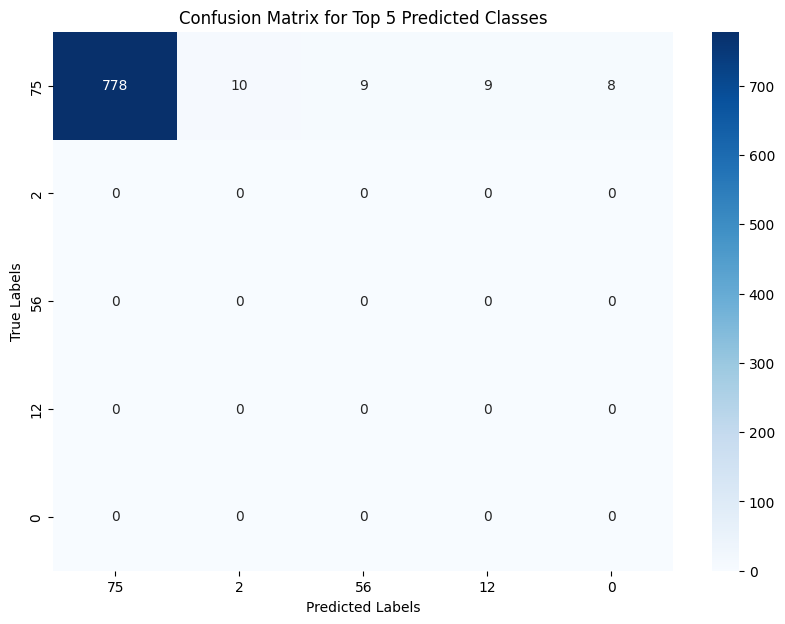

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assume df is your DataFrame with 'Label' (y_true) and 'predict' (y_pred) columns
# Step 1: Find the top 5 most frequent classes in y_pred
top_5_classes = df['predict'].value_counts().nlargest(5).index

# Step 2: Filter the DataFrame to include only rows with these top 5 predicted classes
filtered_df = df[df['predict'].isin(top_5_classes) & df['Label'].isin(top_5_classes)]

# Step 3: Extract the filtered y_true and y_pred
y_true_filtered = filtered_df['Label']
y_pred_filtered = filtered_df['predict']

# Step 4: Compute confusion matrix
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_5_classes)
# Step 5: Plot the confusion matrix using Seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=top_5_classes, yticklabels=top_5_classes, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Top 5 Predicted Classes')
plt.show()


In [61]:
print(len(df[df['predict'] == 75]))
print(len(df[df['predict'] != 75]))

778
109
